In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

from time import time
from datetime import timedelta

In [3]:
X = pd.read_csv('USDA-0.2.csv')
y = X['pct_obese_adults13']

drop_cols = ['fips','pct_obese_adults13']
X.drop(drop_cols, axis=1, inplace=True)

In [4]:
cv = KFold(n_splits=5, shuffle=True, random_state=101)

In [23]:
metric = 'mae'
clf = XGBRegressor(n_jobs=-1,eval_metric=metric, random_state=8)
start = time()
oof_preds = cross_val_predict(clf, X, y, cv=cv, method='predict')
end = time()
diff = end - start
td = timedelta(seconds=diff)
print('Completed in {}'.format(td))
mae = mean_absolute_error(y, oof_preds)
mse = mean_squared_error(y, oof_preds)
rmse = np.sqrt(mse)
print('MAE  {:.4f}'.format(mae))
print('MSE  {:.4f}'.format(mse))
print('RMSE {:.4f}'.format(rmse))
clf = XGBRegressor(n_jobs=-1,eval_metric=metric, random_state=8)
start = time()
clf.fit(X,y)
end = time()
diff = end - start
td = timedelta(seconds=diff)
print('Completed in {}'.format(td))

Completed in 0:00:01.540150
MAE  1.8104
MSE  5.1974
RMSE 2.2798


/home/tad/anaconda3/envs/usda_proj/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/tad/anaconda3/envs/usda_proj/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Completed in 0:00:00.381914


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

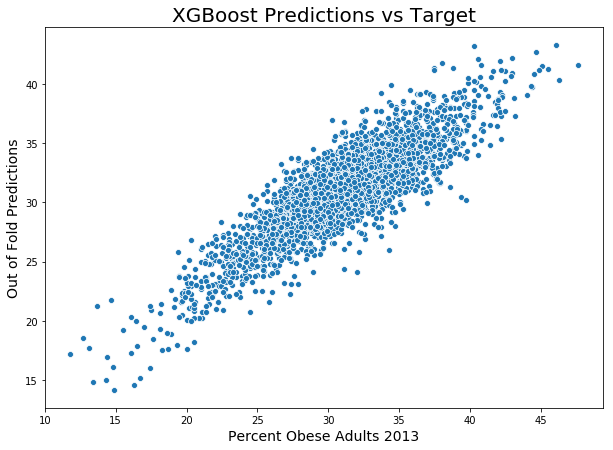

In [25]:
fig, ax = plt.subplots(figsize=(10,7))

sns.scatterplot(y, oof_preds, ax=ax)
ax.set_xlabel('Percent Obese Adults 2013', size=14)
ax.set_ylabel('Out of Fold Predictions', size=14)
ax.set_title('XGBoost Predictions vs Target',size=20)
plt.savefig('xgb pred vs target with diab',dpe=300)
plt.show()

In [26]:
errors = abs(y - oof_preds)

In [27]:
errors.name = 'Absolute Error'

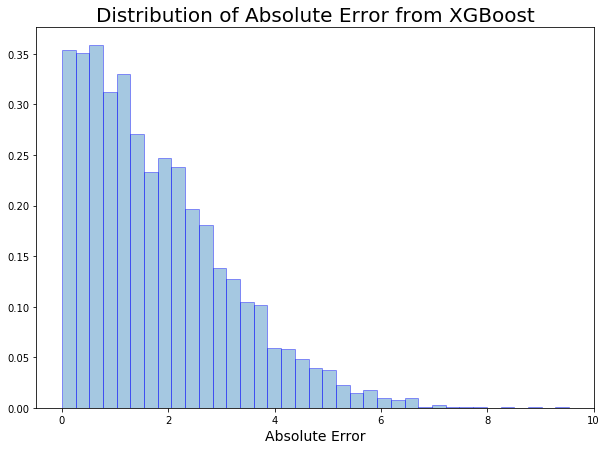

In [28]:
fig, ax = plt.subplots(figsize=(10,7))

sns.distplot(errors, norm_hist=True, kde=False,hist_kws=dict(edgecolor='b'), ax=ax)
ax.set_title('Distribution of Absolute Error from XGBoost',size=20)
ax.set_xlabel('Absolute Error', size=14)
plt.savefig('dist_abs_error_diab_xgb', dpi=300)
plt.show()

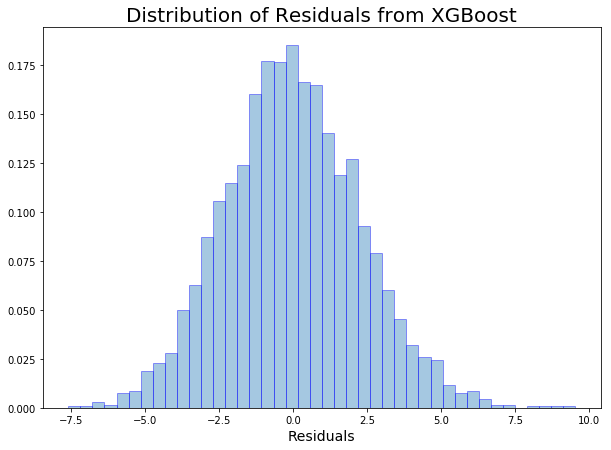

In [32]:
fig, ax = plt.subplots(figsize=(10,7))
residuals = y - oof_preds
sns.distplot(residuals, norm_hist=True, kde=False,hist_kws=dict(edgecolor='b'), ax=ax)
ax.set_title('Distribution of Residuals from XGBoost',size=20)
ax.set_xlabel('Residuals', size=14)
plt.savefig('dist_actual_error_diab_xgb', dpi=300)
plt.show()

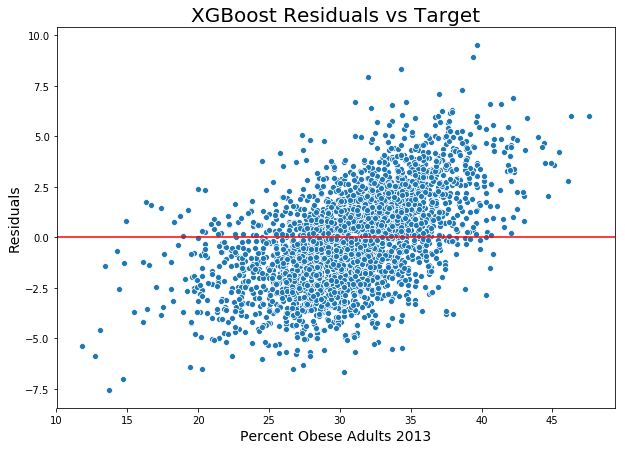

In [30]:
fig, ax = plt.subplots(figsize=(10,7))

sns.scatterplot(y, residuals, ax=ax)
ax.set_xlabel('Percent Obese Adults 2013', size=14)
ax.set_ylabel('Residuals', size=14)
ax.set_title('XGBoost Residuals vs Target',size=20)
ax.axhline(c='red')
plt.savefig('xgb residuals vs target with diab',dpe=300)
plt.show()

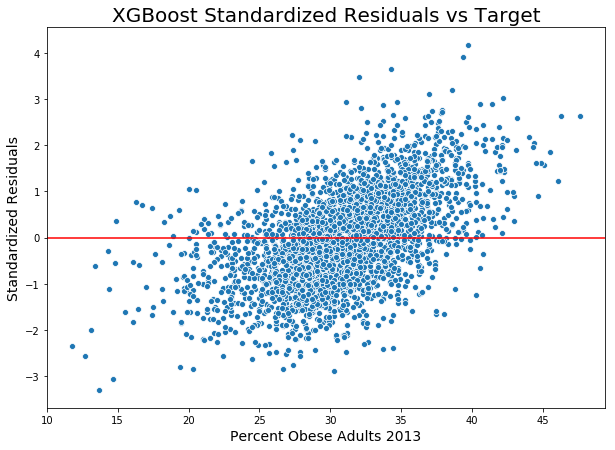

In [31]:
fig, ax = plt.subplots(figsize=(10,7))

sns.scatterplot(y, (residuals - np.mean(residuals))/np.std(residuals), ax=ax)
ax.set_xlabel('Percent Obese Adults 2013', size=14)
ax.set_ylabel('Standardized Residuals', size=14)
ax.set_title('XGBoost Standardized Residuals vs Target',size=20)
ax.axhline(c='red')
plt.savefig('xgb standardized residuals vs target with diab',dpe=300)
plt.show()

In [80]:
feat_imp = pd.DataFrame([(i,j) for i,j in zip(X.columns,clf.feature_importances_)],columns=['Feature','Importance'])
feat_imp.sort_values(by='Importance',ascending=False).head(10)

,Feature,Importance
190,pct_diabetes_adults13,0.111392
99,pc_fsrsales12,0.074783
130,pct_sfsp15,0.064237
98,pc_fsrsales07,0.036404
94,fsrpth14,0.035967
230,school_breakfast_program_participants_fy_2015,0.029988
146,foodinsec_child_03_11,0.029634
213,wic_participants_fy_2009,0.028953
189,pct_diabetes_adults08,0.024574
135,pct_cacfp09,0.024187


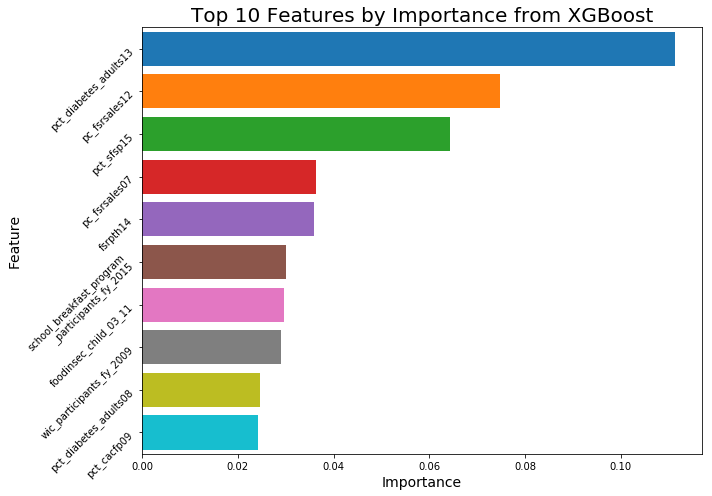

In [98]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x='Importance', y='Feature', 
            data=feat_imp.sort_values(by='Importance', ascending=False).head(10),
           ax=ax, saturation=1.0)
ax.set_title('Top 10 Features by Importance from XGBoost', size=20)
ax.set_ylabel('Feature', size=14)
ax.set_xlabel('Importance', size=14)
labels = []
for i in ax.get_yticklabels():
    if i.get_text().startswith('school'):
        labels.append(i.get_text().replace('program_','program\n_'))
    else:
        labels.append(i.get_text())
ax.set_yticklabels( labels, rotation=45 ) 
plt.tight_layout()
plt.savefig('Top 10 Features by Importance from XGBoost with diab', dpi=300)
plt.show()

In [82]:
variable_data = pd.read_excel('DataDownload.xls',sheet_name='Variable List')
variable_data['Variable Code'] = variable_data['Variable Code'].str.lower()
top_feats = [i for i in feat_imp.sort_values(by='Importance', ascending=False)['Feature'].tolist()][0:10]

In [83]:
variable_data[variable_data['Variable Code'].isin(top_feats)]

,Category Name,Category Code,Subcategory Name,Variable Name,Variable Code,Geography,Units
87,Restaurant Availability and Expenditures,RESTAURANTS,Full-service,"Full-service restaurants/1,000 pop, 2014",fsrpth14,CNTY10,Count
91,Restaurant Availability and Expenditures,RESTAURANTS,Expenditures,"Expenditures per capita, restaurants, 2007*",pc_fsrsales07,CNTY10,Dollars
92,Restaurant Availability and Expenditures,RESTAURANTS,Expenditures,"Expenditures per capita, restaurants, 2012*",pc_fsrsales12,CNTY10,Dollars
123,Food Assistance,ASSISTANCE,Summer Food Service Program,Summer Food Service Program participants (% po...,pct_sfsp15,CNTY10,Percent
134,Food Assistance,ASSISTANCE,Child & Adult Care,"Child & Adult Care (% pop), 2009*",pct_cacfp09,CNTY10,Percent
145,Food Insecurity,INSECURITY,State Food Insecurity,"Child food insecurity (% households, multiple-...",foodinsec_child_03_11,CNTY10,Percent
251,Health and Physical Activity,HEALTH,Health,"Adult diabetes rate, 2008",pct_diabetes_adults08,CNTY10,Percent
252,Health and Physical Activity,HEALTH,Health,"Adult diabetes rate, 2013",pct_diabetes_adults13,CNTY10,Percent


In [84]:
top_feats_lower = [i.lower() for i in top_feats]
top_feats_lower

['pct_diabetes_adults13',
 'pc_fsrsales12',
 'pct_sfsp15',
 'pc_fsrsales07',
 'fsrpth14',
 'school_breakfast_program_participants_fy_2015',
 'foodinsec_child_03_11',
 'wic_participants_fy_2009',
 'pct_diabetes_adults08',
 'pct_cacfp09']

In [85]:
top_data = X[top_feats_lower].join(y)

In [86]:
def scatter(x, y, data, save=None):
    fig, ax = plt.subplots(figsize=(10,7))
    title = '{} vs {}'.format(y,x)
    sns.scatterplot(x, y, data=data, ax=ax)
    ax.set_xlabel(x, size=14)
    ax.set_ylabel(y, size=14)
    ax.set_title(title,size=20)
    if save:
        plt.savefig(title.format(),dpe=300)
    plt.show()

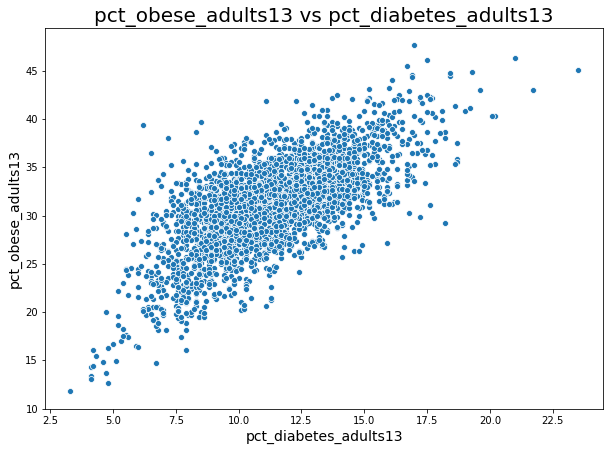

In [87]:
scatter(y=y.name, x='pct_diabetes_adults13', data=top_data)

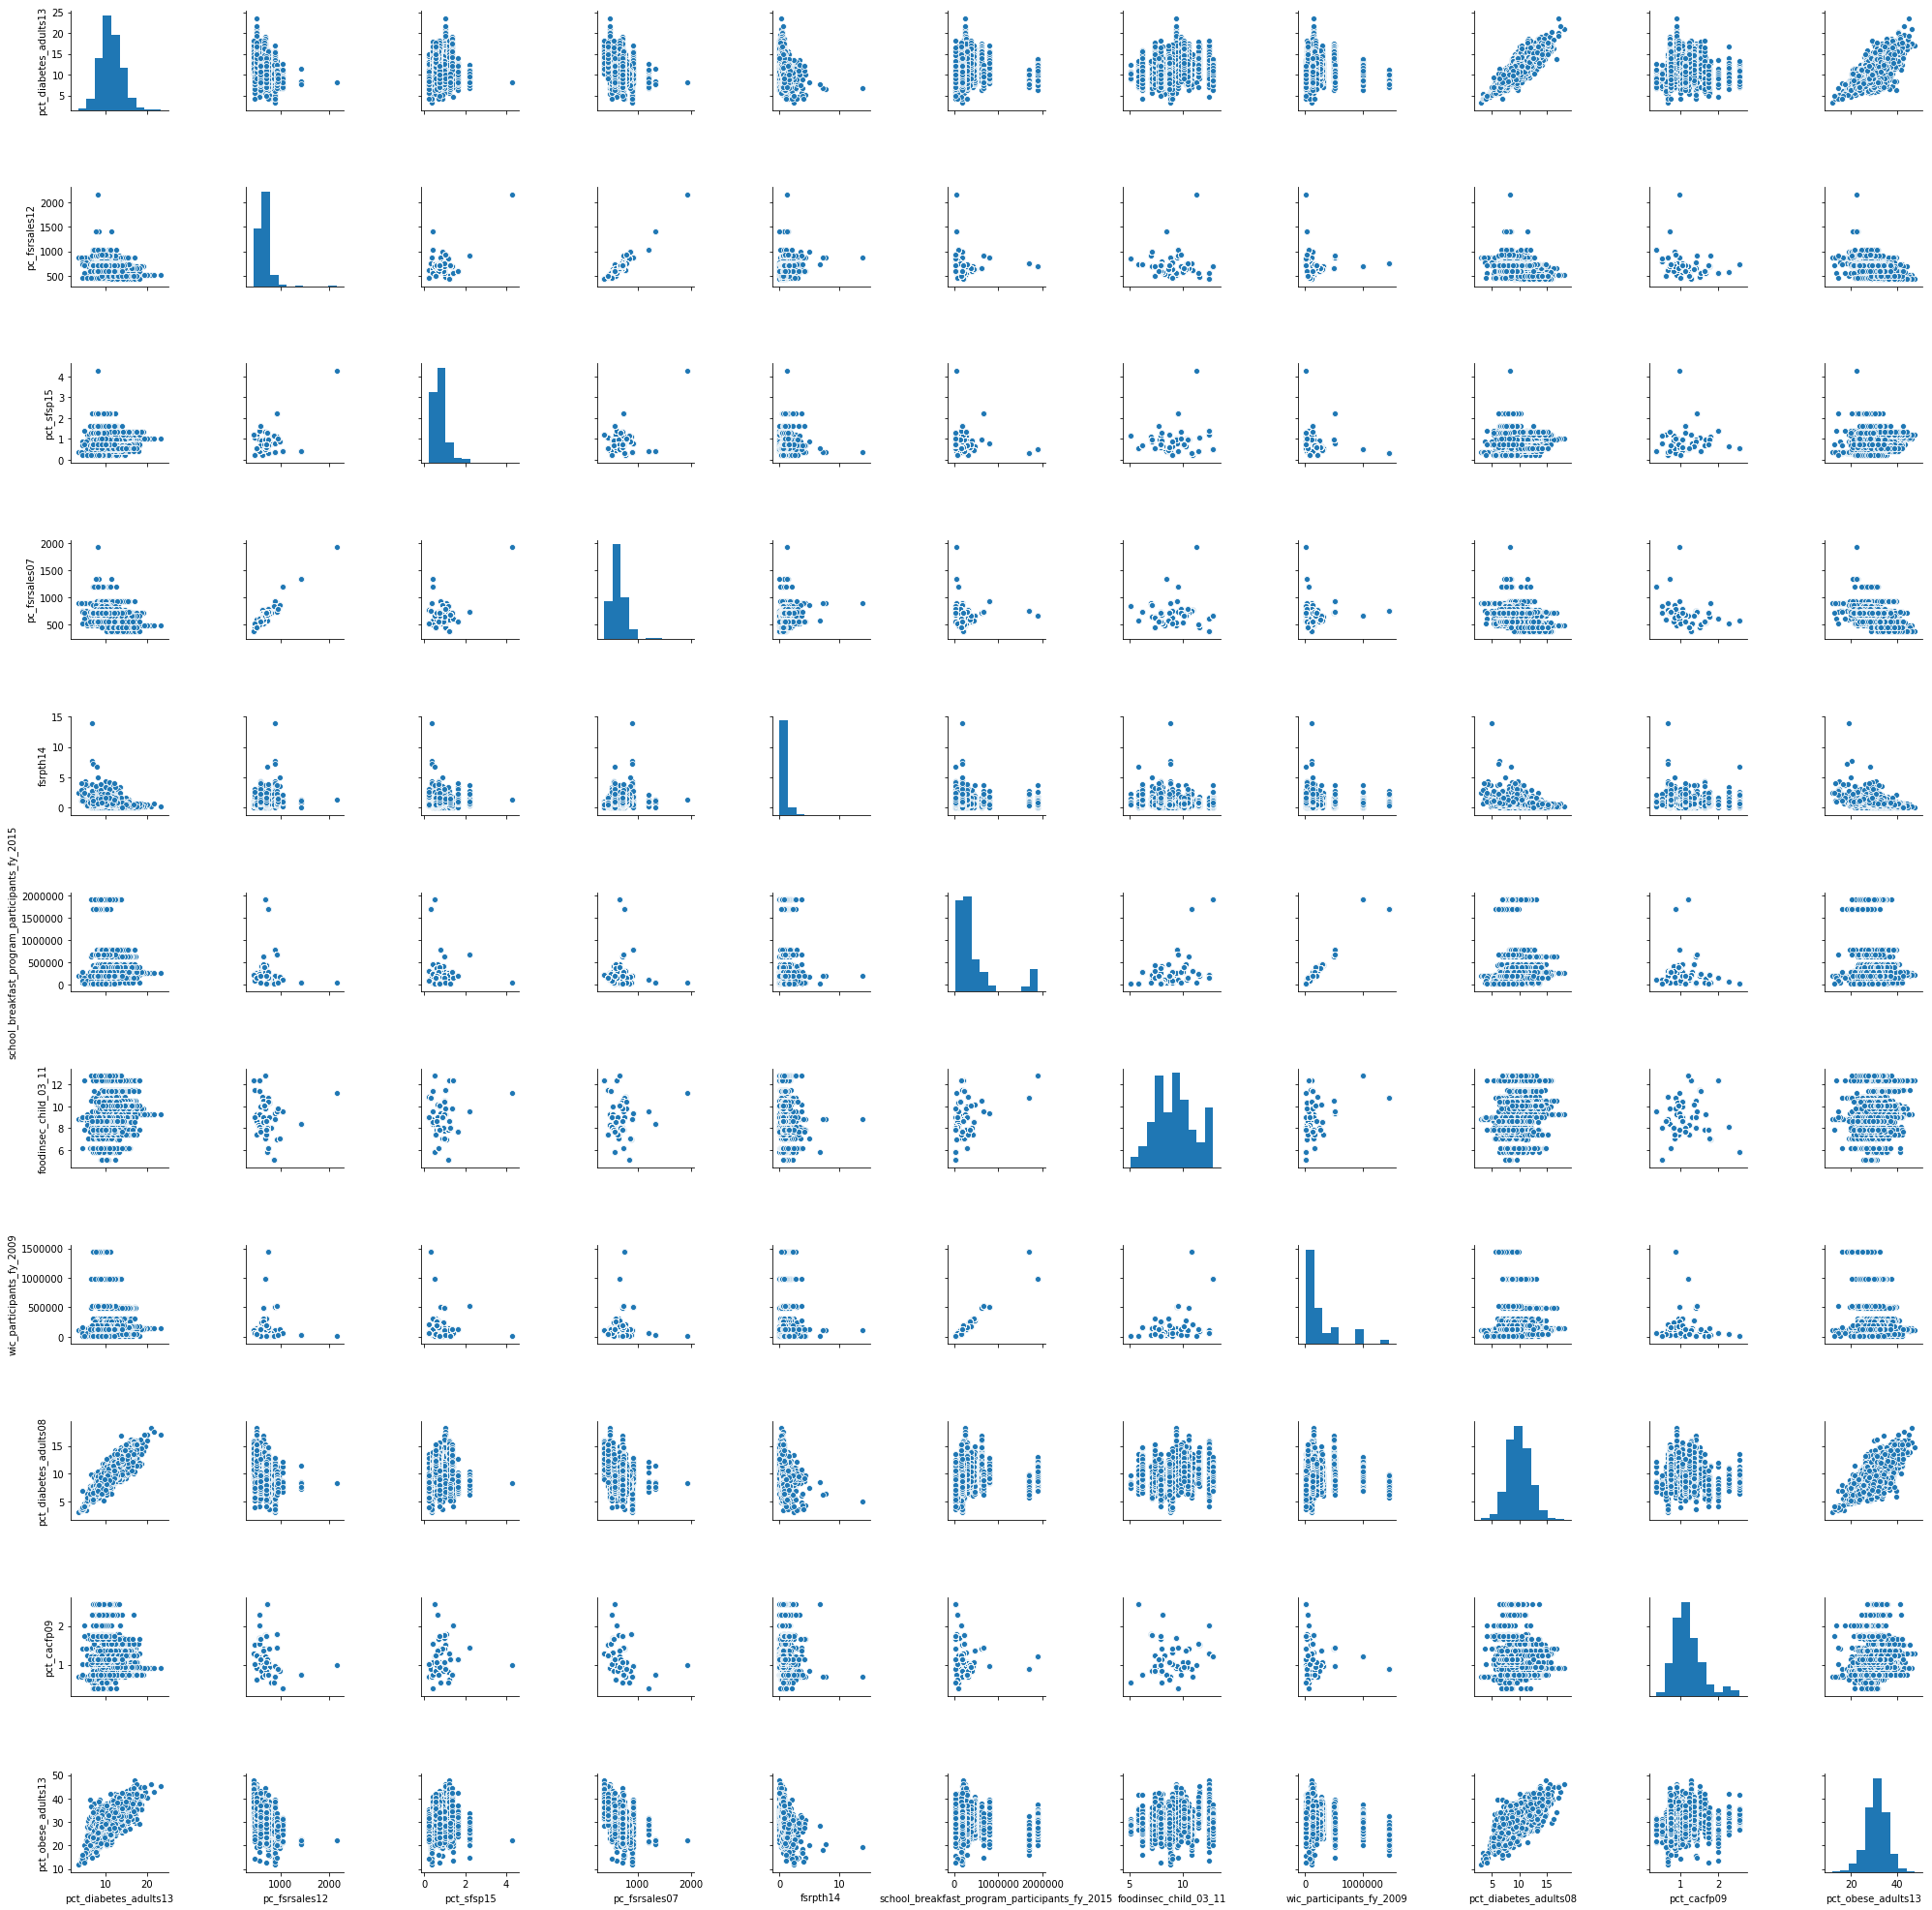

In [88]:
sns.pairplot(top_data)

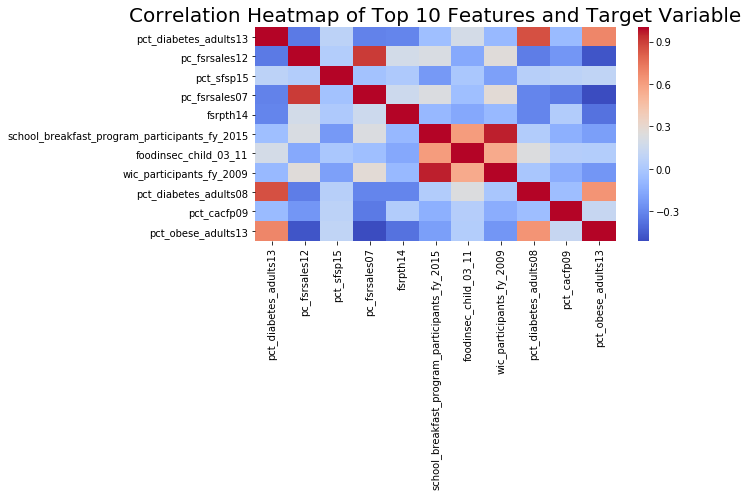

In [89]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(top_data.corr(), ax=ax, cmap="coolwarm")
ax.set_title('Correlation Heatmap of Top 10 Features and Target Variable',size=20)
plt.tight_layout()
plt.savefig('Correlation Heat Map with diab xgb', dpi=300)
plt.show()

In [119]:
imp_type = variable_data.merge(feat_imp,left_on='Variable Code', right_on='Feature')
imp_type.head()

,Category Name,Category Code,Subcategory Name,Variable Name,Variable Code,Geography,Units,Feature,Importance
0,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store, 2010",laccess_pop10,CNTY10,Count,laccess_pop10,0.003730
1,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store, 2015",laccess_pop15,CNTY10,Count,laccess_pop15,0.000039
2,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store (% change), 20...",pch_laccess_pop_10_15,CNTY10,% change,pch_laccess_pop_10_15,0.001707
3,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store (%), 2010",pct_laccess_pop10,CNTY10,Percent,pct_laccess_pop10,0.000029
4,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store (%), 2015",pct_laccess_pop15,CNTY10,Percent,pct_laccess_pop15,0.000000


In [91]:
grouped = imp_type.groupby('Category Name', as_index=False).agg({'Importance': 'sum'})\
.rename({'Importance': 'Category Importance'},axis=1)\
.sort_values(by='Category Importance', ascending=False)
grouped

,Category Name,Category Importance
1,Food Assistance,0.199861
6,Restaurant Availability and Expenditures,0.191323
4,Health and Physical Activity,0.168937
0,Access and Proximity to Grocery Store,0.098961
8,Store Availability,0.084258
7,Socioeconomic Characteristics,0.055498
2,Food Insecurity,0.047184
5,Local Foods,0.046606
3,Food Prices and Taxes,0.015375


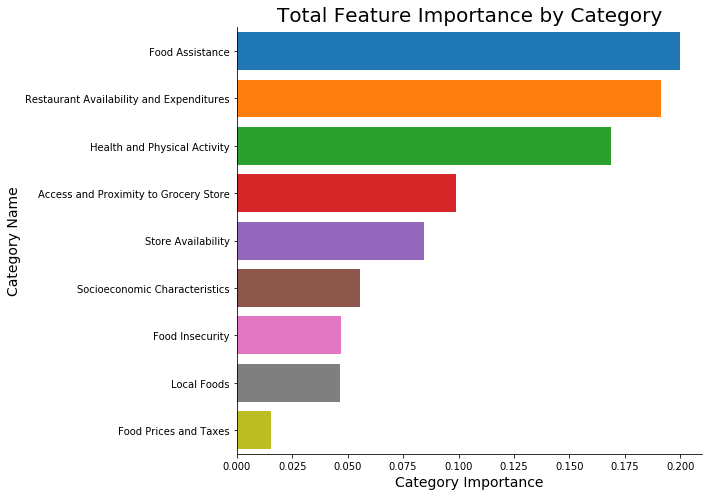

In [109]:
fig, ax = plt.subplots(figsize=(10,7))

sns.barplot(x='Category Importance', y='Category Name', data=grouped, ax=ax, saturation=1.0)
ax.set_xlabel('Category Importance', size=14)
ax.set_ylabel('Category Name', size=14)
ax.set_title('Total Feature Importance by Category', size=20)
sns.despine()
plt.tight_layout()
plt.savefig('Category Importance.png', dpi=300)
plt.show()

In [124]:
X.shape

(3139, 251)

In [121]:
imp_type['Variable Subgroup'] = imp_type['Variable Name'].apply(lambda x: x.split(', ')[0])

In [123]:
imp_type.groupby('Variable Subgroup', as_index=False).agg({'Importance':'sum'})\
.sort_values(by='Importance', ascending=False)

,Variable Subgroup,Importance
8,Adult diabetes rate,0.135966
28,Expenditures per capita,0.126350
109,Summer Food Service Program participants (% pop),0.081298
44,"Full-service restaurants/1,000 pop",0.042866
17,Child food insecurity (% households,0.029634
48,Grocery stores,0.028475
15,Child & Adult Care (% pop),0.025530
76,Recreation & fitness facilities,0.024602
58,Households,0.023162
98,Seniors,0.018095


In [117]:
imp_type[imp_type['Category Name']=='Food Assistance']['Variable Name']\
.apply(lambda x: x.split(', ')[0]).value_counts()

SNAP participants (% eligible pop)                           2
WIC participants (% pop)                                     2
Students eligible for reduced-price lunch (%)                2
Child & Adult Care (% pop)                                   2
SNAP redemptions/SNAP-authorized stores                      2
Students eligible for free lunch (%)                         2
SNAP participants (% pop)                                    2
SNAP online application                                      2
National School Lunch Program participants (% pop)           2
SNAP Broad-based Categorical Eligibility                     2
SNAP Combined Application Project                            2
School Breakfast Program participants (% pop)                2
SNAP benefits per capita                                     2
Summer Food Service Program participants (% pop)             2
SNAP simplified reporting                                    2
WIC participants (change % pop)                        

In [116]:
imp_type[imp_type['Category Name']=='Restaurant Availability and Expenditures']['Variable Name']\
.apply(lambda x: x.split(', ')[0]).value_counts()

Expenditures per capita                          4
Full-service restaurants/1,000 pop               2
Full-service restaurants                         2
Fast-food restaurants/1,000 pop                  2
Fast-food restaurants                            2
Fast-food restaurants/1,000 pop (% change)       1
Full-service restaurants/1,000 pop (% change)    1
Fast-food restaurants (% change)                 1
Full-service restaurants (% change)              1
Name: Variable Name, dtype: int64

In [129]:
imp_type[imp_type['Category Name']=='Health and Physical Activity']

,Category Name,Category Code,Subcategory Name,Variable Name,Variable Code,Geography,Units,Feature,Importance,Variable Subgroup
181,Health and Physical Activity,HEALTH,Health,"Adult diabetes rate, 2008",pct_diabetes_adults08,CNTY10,Percent,pct_diabetes_adults08,0.024574,Adult diabetes rate
182,Health and Physical Activity,HEALTH,Health,"Adult diabetes rate, 2013",pct_diabetes_adults13,CNTY10,Percent,pct_diabetes_adults13,0.111392,Adult diabetes rate
183,Health and Physical Activity,HEALTH,Physical Activity,"Recreation & fitness facilities, 2009",recfac09,CNTY10,Count,recfac09,0.011874,Recreation & fitness facilities
184,Health and Physical Activity,HEALTH,Physical Activity,"Recreation & fitness facilities, 2014",recfac14,CNTY10,Count,recfac14,0.012728,Recreation & fitness facilities
185,Health and Physical Activity,HEALTH,Physical Activity,"Recreation & fitness facilities (% change), 20...",pch_recfac_09_14,CNTY10,% change,pch_recfac_09_14,0.001429,Recreation & fitness facilities (% change)
186,Health and Physical Activity,HEALTH,Physical Activity,"Recreation & fitness facilities/1,000 pop, 2009",recfacpth09,CNTY10,"# per 1,000 pop",recfacpth09,0.004219,"Recreation & fitness facilities/1,000 pop"
187,Health and Physical Activity,HEALTH,Physical Activity,"Recreation & fitness facilities/1,000 pop, 2014",recfacpth14,CNTY10,"# per 1,000 pop",recfacpth14,0.002721,"Recreation & fitness facilities/1,000 pop"
188,Health and Physical Activity,HEALTH,Physical Activity,"Recreation & fitness facilities/1,000 pop (% c...",pch_recfacpth_09_14,CNTY10,% change,pch_recfacpth_09_14,0.000000,"Recreation & fitness facilities/1,000 pop (% c..."
